In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import warnings
from colorama import Fore, Back, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
from lightgbm import LGBMClassifier, log_evaluation

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

INFERENCE = True # set to False if you only want to cross-validate


In [4]:
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

# Reading and preprocessing the data

We read the data from @raddar's [dataset](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format). @raddar has [denoised the data](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514) so that we can achieve better results with his dataset than with the original competition csv files.

Then we create three groups of features:
- Selected features averaged over all statements of a customer
- The minimum or maximum of selected features over all statements of a customer
- Selected features taken from the last statement of a customer

The code has been optimized for memory efficiency rather than readability. In particular, `.iloc[mask_array, columns]` needs much less RAM than the groupby construction used in a previous version of the notebook.

Preprocessing for LightGBM is much simpler than for neural networks:
1. Neural networks can't process missing values; LightGBM handles them automatically.
1. Categorical features need to be one-hot encoded for neural networks; LightGBM handles them automatically.
1. With neural networks, you need to think about outliers; tree-based algorithms deal with outliers easily.
1. Neural networks need scaled inputs; tree-based algorithms don't depend on scaling.

In [5]:
%%time
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
for i in ['test', 'train'] if INFERENCE else ['train']:
    df = pd.read_parquet(f'../input/amex-data-integer-dtypes-parquet-format/{i}.parquet')
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1)) # mask for last statement of every customer
    if 'target' in df.columns:
        df.drop(columns=['target'], inplace=True)
    gc.collect()
    print('Read', i)
    df_avg = (df
              .groupby(cid)
              .mean()[features_avg]
              .rename(columns={f: f"{f}_avg" for f in features_avg})
             )
    gc.collect()
    print('Computed avg', i)
    df_min = (df
              .groupby(cid)
              .min()[features_min]
              .rename(columns={f: f"{f}_min" for f in features_min})
             )
    gc.collect()
    print('Computed min', i)
    df_max = (df
              .groupby(cid)
              .max()[features_max]
              .rename(columns={f: f"{f}_max" for f in features_max})
             )
    gc.collect()
    print('Computed max', i)
    df = (df.loc[last, features_last]
          .rename(columns={f: f"{f}_last" for f in features_last})
          .set_index(np.asarray(cid[last]))
         )
    gc.collect()
    print('Computed last', i)
    df = pd.concat([df, df_min, df_max, df_avg], axis=1)
    if i == 'train': train = df
    else: test = df
    print(f"{i} shape: {df.shape}")
    del df, df_avg, df_min, df_max, cid, last

target = pd.read_csv('../input/amex-default-prediction/train_labels.csv').target.values
print(f"target shape: {target.shape}")

Read test
Computed avg test
Computed min test
Computed max test
Computed last test
test shape: (924621, 469)
Read train
Computed avg train
Computed min train
Computed max train
Computed last train
train shape: (458913, 469)
target shape: (458913,)
CPU times: user 5min 11s, sys: 34.7 s, total: 5min 46s
Wall time: 6min 3s


# Cross-validation

We cross-validate with a five-fold StratifiedKFold because the classes are imbalanced.

Notice that lightgbm logs the validation score with the competition's scoring function every hundred iterations.

In [11]:
%%time
# Cross-validation of the classifier

ONLY_FIRST_FOLD = False

features = [f for f in train.columns if f != 'customer_ID' and f != 'target']

def my_booster(random_state=1, n_estimators=1200):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=95,
                          colsample_bytree=0.19,
                          max_bins=511, random_state=random_state)
      
print(f"{len(features)} features")
score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=2)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    X_tr, X_va, y_tr, y_va, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = target[idx_tr]
    y_va = target[idx_va]
    
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(100)])
    X_tr, y_tr = None, None
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    score = amex_metric(y_va, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    
    if INFERENCE:
        y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    if ONLY_FIRST_FOLD: break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

469 features
[100]	valid_0's binary_logloss: 0.249203	valid_0's amex: 0.759651
[200]	valid_0's binary_logloss: 0.229374	valid_0's amex: 0.775584
[300]	valid_0's binary_logloss: 0.224063	valid_0's amex: 0.782782
[400]	valid_0's binary_logloss: 0.221696	valid_0's amex: 0.785544
[500]	valid_0's binary_logloss: 0.220422	valid_0's amex: 0.787442
[600]	valid_0's binary_logloss: 0.219684	valid_0's amex: 0.788375
[700]	valid_0's binary_logloss: 0.219172	valid_0's amex: 0.789421
[800]	valid_0's binary_logloss: 0.218837	valid_0's amex: 0.789629
[900]	valid_0's binary_logloss: 0.218684	valid_0's amex: 0.789764
[1000]	valid_0's binary_logloss: 0.218616	valid_0's amex: 0.789122
[1100]	valid_0's binary_logloss: 0.218564	valid_0's amex: 0.789873
[1200]	valid_0's binary_logloss: 0.218572	valid_0's amex: 0.78961
Fold 0 | 03:21 |  1200 trees |                Score = 0.79022
[100]	valid_0's binary_logloss: 0.247903	valid_0's amex: 0.762131
[200]	valid_0's binary_logloss: 0.227115	valid_0's amex: 0.777222

# Prediction histogram

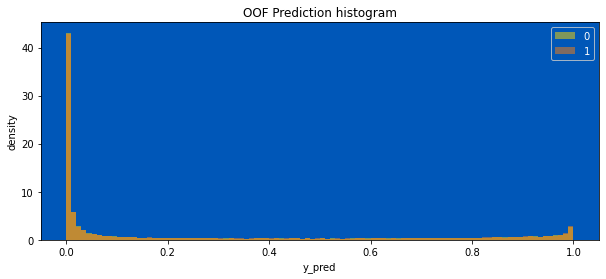

In [7]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

plt.figure(figsize=(10, 4))
plt.hist(sigmoid(y_va_pred[y_va == 0]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='0')
plt.hist(sigmoid(y_va_pred[y_va == 1]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

# Calibration diagram

The calibration diagram shows how the model predicts the default probability of customers:

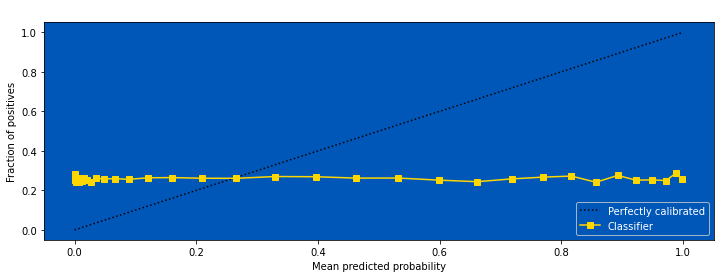

In [9]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, sigmoid(y_va_pred), n_bins=50,
                                    strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

# Submission

We submit the mean of the five predictions. As proposed by @lucasmorin, we [take the mean of the log odds](https://www.kaggle.com/competitions/amex-default-prediction/discussion/329103) rather than of the probabilities.

In [12]:
if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.863270
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-7.348307
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-2.984148
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-1.132406
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.873516
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.933397
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.131778
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,-0.123648
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.666471


As a final check, we verify that the test prediction distribution equals the validation prediction distribution. 

In [ ]:
plt.figure(figsize=(12, 4))
plt.hist(sigmoid(sub.prediction), bins=np.linspace(0, 1, 101), density=True)
plt.hist(sigmoid(y_va_pred), bins=np.linspace(0, 1, 101), rwidth=0.5, color='orange', density=True)
plt.show()